# Machine Learning Tests

## Setup

In [1]:
import mne
import re
import os
import numpy as np
import source_localization as srcl
import MEG_analysis as meg
import machine_learning as ml
import matplotlib.pyplot as plt
import sklearn

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression, LinearRegression

from scipy.io import loadmat

from mne.minimum_norm import apply_inverse_epochs, read_inverse_operator
from mne.decoding import (cross_val_multiscore, LinearModel, SlidingEstimator,
                          get_coef, Vectorizer, Scaler)

%matplotlib inline

In [2]:
behavior_lst = {
    "KA": "01amano1101/amano1101_session_20161101T132416",
    "SoM": "02minami1101/minami1101_session_20161101T145905",
    "MF": "07fujita0131/fujita0131_session_20170131T145759",
    "MK":  "12kawaguchi0731/kawaguchi0731_session_20170731T153637",
    "NNo": "19noguchi0808/noguchi0808_session_20170808T102813",
}

In [15]:
y, _ = ml.load_y("NN", n_classes=4)

In [16]:
hist = {0: 0, 1: 0, 2: 0, 3: 0}

for i in y:
    hist[i] += 1

print(hist)

{0: 99, 1: 94, 2: 116, 3: 91}


In [3]:
folder_dict = meg.get_folder_dict()
#subj = 'MF-aligned'
#subj = 'MK-aligned'
subj = 'NNo-4'
meg_dir = '../../../../MEG_raw01/170808_noguchi_SD'
should_save_evoked_figs = False
should_train_model = True
source_localization_dir = "/usr/local/freesurfer/subjects"

In [4]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
src, bem = srcl.get_processed_mri_data(subj, source_localization_dir)
cov = mne.compute_covariance(epochs, tmax=0., method=['shrunk', 'empirical'], rank=None, verbose=True)
fwd = srcl.make_forward_sol(evoked, src, bem, "%s/%s-trans.fif" % (meg_dir, subj))

Reading ../Data/Epochs/NNo-4-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
801 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 projection i

In [5]:
def calc_accuracy(y_pred, y_test):
    total = 0
    for i in range(len(y_pred)):
        if y_pred[i] == y_test[i]:
            total+=1

    return total / len(y_pred)

In [6]:
def generate_y(behavior_subj, n_trials, n_classes=2):
    y = []
    for i in range(n_trials):
        #y_path = "../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block%s_data.mat" % (i + 1)
        y_path = "../../../../MEG/Behaviour/" + behavior_lst[behavior_subj] + "_block%s_data.mat" % (i + 1)
        y += ml.generate_y_classes(y_path, n_classes)
        
    y = np.array(y)
    return y

In [7]:
generate_y("NNo", 6).shape

(600,)

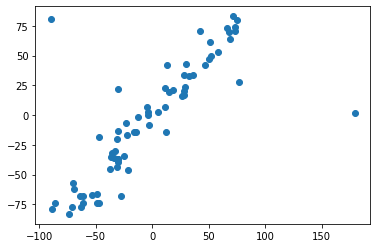

In [8]:
data = loadmat("../../../../MEG/Behaviour/07fujita0131/fujita0131_session_20170131T145759_block6_data.mat")
response = data["GabOrSpec"]
target = data["TargetGabor"]

plt.scatter(response, target)

## RNN model

### Initialize Train, Test Data

In [9]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 8017/8196 = 10.001055
    scale = 1.14486e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 1.3e-13 (2.2e-16 eps * 204 dim * 2.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [10]:
X = np.einsum('ikj->ijk', np.array([next(stc_epoch).crop(0, 0.4, False).bin(0.025).data for i in range(600)]))
X_train, X_test = X[:500], X[500:]
del stc_epoch
del X

93 / 801
combining the current components...
Processing epoch : 294 / 801
combining the current components...
Processing epoch : 295 / 801
combining the current components...
Processing epoch : 296 / 801
combining the current components...
Processing epoch : 297 / 801
combining the current components...
Processing epoch : 298 / 801
combining the current components...
Processing epoch : 299 / 801
combining the current components...
Processing epoch : 300 / 801
combining the current components...
Processing epoch : 301 / 801
combining the current components...
Processing epoch : 302 / 801
combining the current components...
Processing epoch : 303 / 801
combining the current components...
Processing epoch : 304 / 801
combining the current components...
Processing epoch : 305 / 801
combining the current components...
Processing epoch : 306 / 801
combining the current components...
Processing epoch : 307 / 801
combining the current components...
Processing epoch : 308 / 801
combining the cu

In [49]:
print(X_test.shape)

(100, 204, 32)


In [11]:
y = generate_y("NNo", 6, n_classes=5)
y_hot = np.zeros((y.size, int(y.max()) + 1))
y_hot[np.arange(y.size), y.astype(int)] = 1
y_train, y_test = y_hot[:500], y_hot[500:]

### Train model with RNN

In [12]:
model = ml.LogisticRNNModel(n_epochs=10, n_outputs=5)
model.fit(X_train, y_train)

Epoch 1/10
50/50 [==============================] - 1s 11ms/step - loss: 2.2977 - accuracy: 0.1660
Epoch 2/10
50/50 [==============================] - 1s 11ms/step - loss: 1.7489 - accuracy: 0.2300
Epoch 3/10
50/50 [==============================] - 1s 11ms/step - loss: 1.5988 - accuracy: 0.2820
Epoch 4/10
50/50 [==============================] - 1s 11ms/step - loss: 1.5438 - accuracy: 0.3380
Epoch 5/10
50/50 [==============================] - 1s 11ms/step - loss: 1.4435 - accuracy: 0.3760
Epoch 6/10
50/50 [==============================] - 1s 11ms/step - loss: 1.4266 - accuracy: 0.3840
Epoch 7/10
50/50 [==============================] - 1s 11ms/step - loss: 1.3976 - accuracy: 0.4080
Epoch 8/10
50/50 [==============================] - 1s 11ms/step - loss: 1.3950 - accuracy: 0.4040
Epoch 9/10
50/50 [==============================] - 1s 11ms/step - loss: 1.3372 - accuracy: 0.4320
Epoch 10/10
50/50 [==============================] - 1s 11ms/step - loss: 1.2910 - accuracy: 0.4240


### Evaluate Performance

In [13]:
model.evaluate(X_train, y_train)

16/16 [==============================] - 0s 5ms/step - loss: 1.3279 - accuracy: 0.3880


0.3880000114440918

In [14]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_test = y[500:]
accuracy = calc_accuracy(y_pred, y_test)
print(accuracy)

0.23


## Train mne model

In [69]:
inv_op_epoch = mne.minimum_norm.make_inverse_operator(epochs.info, fwd, cov, loose=0.2, depth=0.8)
stc_epoch = mne.minimum_norm.apply_inverse_epochs(epochs, inv_op_epoch, 0.11, return_generator=True)

Converting forward solution to surface orientation
    Average patch normals will be employed in the rotation to the local surface coordinates....
    Converting to surface-based source orientations...
    [done]
Computing inverse operator with 204 channels.
    204 out of 204 channels remain after picking
Selected 204 channels
Creating the depth weighting matrix...
    204 planar channels
    limit = 8017/8196 = 10.001055
    scale = 1.14486e-08 exp = 0.8
Applying loose dipole orientations to surface source spaces: 0.2
Whitening the forward solution.
    Created an SSP operator (subspace dimension = 5)
Computing rank from covariance with rank=None
    Using tolerance 1.3e-13 (2.2e-16 eps * 204 dim * 2.9  max singular value)
    Estimated rank (grad): 199
    GRAD: rank 199 computed from 204 data channels with 5 projectors
    Setting small GRAD eigenvalues to zero (without PCA)
Creating the source covariance matrix
Adjusting source covariance matrix.
Computing SVD of whitened and weig

In [70]:
X = np.array([next(stc_epoch).crop(0, 0.4).bin(0.025).lh_data for i in range(600)])
X_train, X_test = X[:500], X[500:]
del stc_epoch
del X

93 / 801
combining the current components...
Processing epoch : 294 / 801
combining the current components...
Processing epoch : 295 / 801
combining the current components...
Processing epoch : 296 / 801
combining the current components...
Processing epoch : 297 / 801
combining the current components...
Processing epoch : 298 / 801
combining the current components...
Processing epoch : 299 / 801
combining the current components...
Processing epoch : 300 / 801
combining the current components...
Processing epoch : 301 / 801
combining the current components...
Processing epoch : 302 / 801
combining the current components...
Processing epoch : 303 / 801
combining the current components...
Processing epoch : 304 / 801
combining the current components...
Processing epoch : 305 / 801
combining the current components...
Processing epoch : 306 / 801
combining the current components...
Processing epoch : 307 / 801
combining the current components...
Processing epoch : 308 / 801
combining the cu

In [71]:
y = generate_y("NNo", 6, n_classes=5)
y_train, y_test = y[:500], y[500:]

In [120]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=1000),  # select features for speed
                    LinearModel(LogisticRegression(C=0.04, solver='saga', l1_ratio=0.9, penalty='elasticnet', max_iter=500)))
#time_decod = SlidingEstimator(clf, scoring=roc_auc_ovo)
time_decod = SlidingEstimator(clf, scoring="accuracy")

scores = cross_val_multiscore(time_decod, X_train, y_train, cv=5, n_jobs=1)

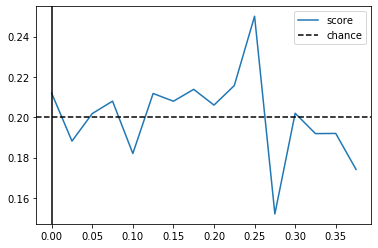

In [121]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, 0.375, 16), scores.mean(0), label='score')
ax.axhline(.2, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()
plt.show()

In [130]:
time_decod.fit(X_train, y_train)

<SlidingEstimator(base_estimator=Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
                 SelectKBest(k=1000,
                             score_func=<function f_classif at 0x7f3e2d460440>)),
 ...lver='saga', tol=0.0001, verbose=0,
                   warm_start=False)))],
         verbose=False),
         n_jobs=1, scoring='accuracy', verbose=None, fitted with 16 estimators>

In [131]:
y_pred = time_decod.predict(X_train)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_train) for i in range(16)]
print(max(accuracy_lst))


0.416


In [132]:
y_pred = time_decod.predict(X_test)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_test) for i in range(16)]
print(max(accuracy_lst))


0.25


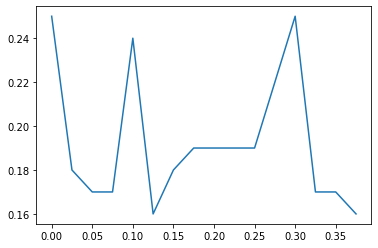

In [133]:
plt.plot(np.linspace(0, 0.375, 16), accuracy_lst)

### Test for random y values

In [128]:
y_rand = np.random.randint(2, size=100)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_rand) for i in range(16)]
print(max(accuracy_lst))

0.31


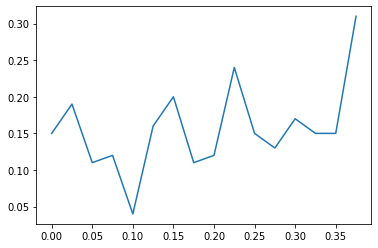

In [129]:
plt.plot(np.linspace(0, 0.375, 16), accuracy_lst)

## Test with just epochs data

In [134]:
epochs, evoked = meg.get_processed_meg_data(subj, folder_dict, meg_dir)
epochs.pick_types(meg=True)

Reading ../Data/Epochs/NNo-4-epo.fif ...
    Read a total of 10 projection items:
        grad_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        grad_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v1 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v2 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v3 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v4 (1 x 360) active
        mag_68_noIAS_20140702-2.fif : PCA-v5 (1 x 360) active
    Found the data of interest:
        t =    -500.00 ...    1000.00 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
801 matching events found
Applying baseline correction (mode: mean)
Created an SSP operator (subspace dimension = 5)
10 projection i

<EpochsFIF |  801 events (all good), -0.5 - 1 sec, baseline [-0.5, 0], ~1.84 GB, data loaded,
 '16384': 801>

In [135]:
epochs.resample(40)
print(epochs.get_data().shape)

(801, 204, 60)


In [136]:
labels = epochs.events[:, -1]
meg_epochs = epochs.copy().pick_types(meg=True, eeg=False).crop(0, 0.4, False)
meg_data = meg_epochs.get_data()

In [137]:
print(meg_data.shape)

(801, 204, 16)


In [138]:
y = generate_y("NNo", 6, 5)
X = meg_data

X_train, X_test = X[:500], X[500:600]
y_train, y_test = y[:500], y[500:]

In [188]:
# prepare a series of classifier applied at each time sample
clf = make_pipeline(StandardScaler(),  # z-score normalization
                    SelectKBest(f_classif, k=200),  # select features for speed
                    LinearModel(LogisticRegression(C=0.08, solver='saga', l1_ratio=0.9, penalty='elasticnet', max_iter=800)))
time_decod = SlidingEstimator(clf, scoring="accuracy")

scores = cross_val_multiscore(time_decod, X_train, y_train, cv=5, n_jobs=1)

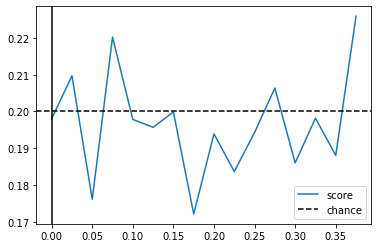

In [189]:
# Plot average decoding scores of 5 splits
fig, ax = plt.subplots(1)
ax.plot(np.linspace(0, 0.375, 16), scores.mean(0), label='score')
ax.axhline(.2, color='k', linestyle='--', label='chance')
ax.axvline(0, color='k')
plt.legend()
plt.show()

In [190]:
time_decod.fit(X_train, y_train)

<SlidingEstimator(base_estimator=Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('selectkbest',
                 SelectKBest(k=200,
                             score_func=<function f_classif at 0x7f3e2d460440>)),
  ...lver='saga', tol=0.0001, verbose=0,
                   warm_start=False)))],
         verbose=False),
         n_jobs=1, scoring='accuracy', verbose=None, fitted with 16 estimators>

In [191]:
y_pred = time_decod.predict(X_train)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_train) for i in range(16)]
print(max(accuracy_lst))


0.432


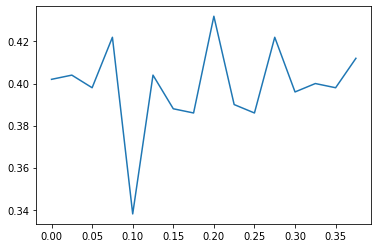

In [192]:
plt.plot(np.linspace(0, 0.375, 16), accuracy_lst)

In [193]:
y_pred = time_decod.predict(X_test)
accuracy_lst = [calc_accuracy(y_pred[:, i], y_test) for i in range(16)]
print(max(accuracy_lst))


0.25


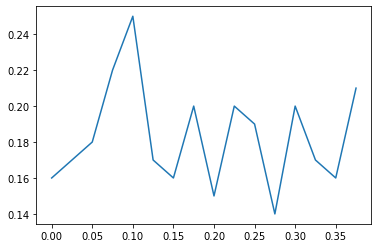

In [194]:
plt.plot(np.linspace(0, 0.375, 16), accuracy_lst)